### 볼린저 밴드 투자 전략 
1. 이동 평균선 : 데이터의 20개의 평균값
2. 상단 밴드 : 이동 평균선 + (2 * 20개의 데이터의 표준편차)
3. 하단 밴드 : 이동 평균선 - (2 * 20개의 데이터의 표준편차)
4. 매수 타이밍 : 하단 밴드보다 이하로 가격이 떨어졌을때
5. 매도 타이밍 : 상단 밴드보다 이상으로 가격이 올랐을때

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [ ]:
df = pd.read_csv("../../csv/MSFT.csv")
df.head()

In [ ]:
# 데이터프레임의 정보 확인 
df.info()

In [10]:
# Date 컬럼의 데이터를 시계열로 변경하고 인덱스 설정
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [11]:
# 결측치, 양의 무한대, 음의 무한대를 제외
flag = df.isin( [np.nan, np.inf, -np.inf] ).any(axis=1)
df = df.loc[~flag, ['Adj Close']]

In [ ]:
df

In [12]:
df.head()

,Adj Close
Date,
1986-03-13,0.069996
1986-03-14,0.072496
1986-03-17,0.073746
1986-03-18,0.071871
1986-03-19,0.070621


In [18]:
# 이동 평균선 생성 
# 20개의 데이터의 평균 값
df.iloc[1:21, 0].mean()

0.06933975

In [15]:
df2 = df.copy()

In [16]:
# 반복문을 이용하여 이동평균선 생성
df2['center'] = np.nan

In [ ]:
for i in range(20, len(df2)+1):
    mean_data = df2.iloc[i-20 : i, 0].mean()
    # 평균값을 i번째 인덱스에 두번째 컬럼(1)에 대입입
    df2.iloc[i-1, 1] = mean_data
df2

In [23]:
# rolling(n) : n만큼 데이터를 그룹화
df['center'] = df['Adj Close'].rolling(20).mean()

In [ ]:
df.iloc[18:22]

In [28]:
# 상단밴드 생성 
df['up'] = \
    df['center'] + (2 * df['Adj Close'].rolling(20).std())

In [29]:
# 하단 밴드 생성
df['down'] = \
    df['center'] - (2 * df['Adj Close'].rolling(20).std())

In [30]:
df_test = df.tail(100)

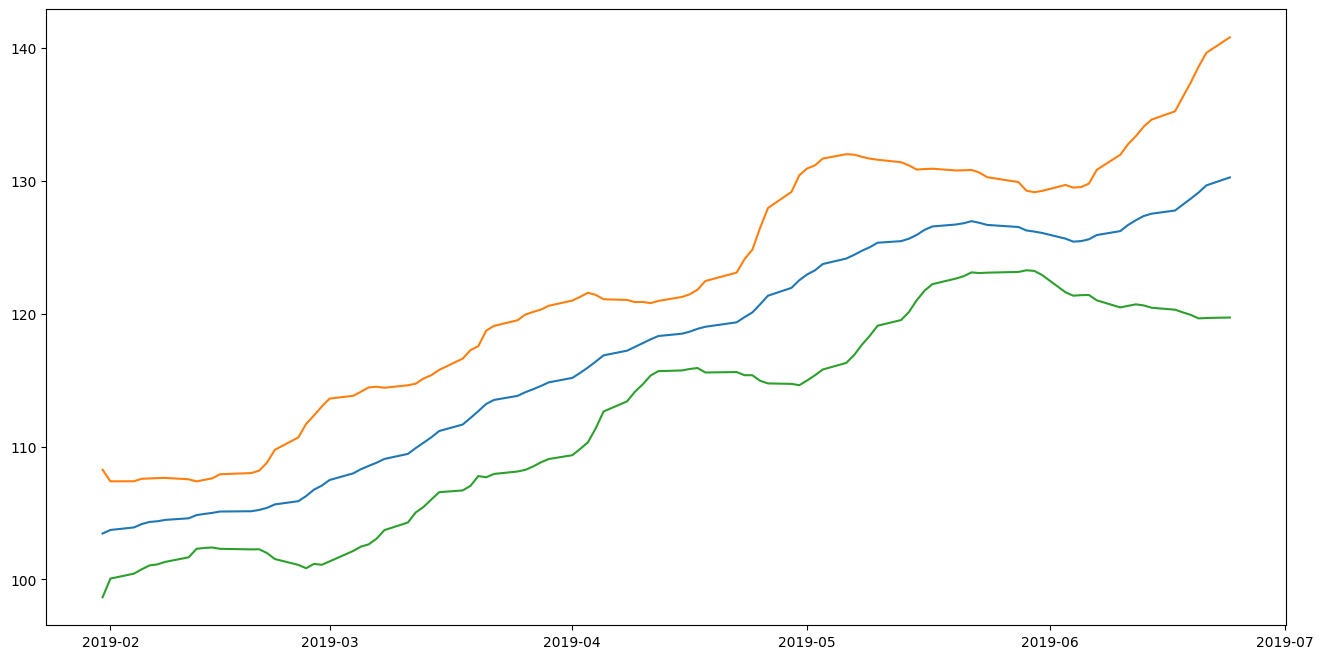

In [31]:
x = df_test.index
center_price = df_test['center']
up_price = df_test['up']
down_price = df_test['down']

plt.figure(figsize = (16, 8))
plt.plot(x, center_price)
plt.plot(x, up_price)
plt.plot(x, down_price)

plt.show()

<AxesSubplot: xlabel='Date'>

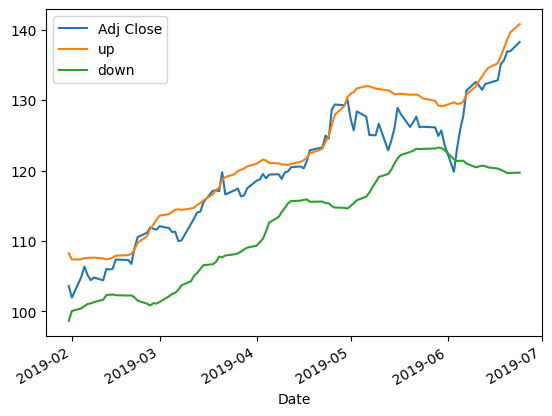

In [32]:
df_test[ ['Adj Close', 'up', 'down'] ].plot()

In [33]:
start = '2010-01-01'

In [34]:
start = datetime.strptime(start, '%Y-%m-%d')

In [36]:
price_df = df.loc[start : ]

### 보유 내역 추가 
- 조건식 
    - 상단 밴드보다 수정 종가가 높거나 같은 경우
        - 현재 보유 상태라면
            - 매도 (trade = '')
        - 현재 보유 상태가 아니면
            - 유지 (trade = '')
    - 상단 밴드보다 낮고 하단 밴드보다 높은 경우 
        - 현재 보유 상태라면 
            - 유지 (trade = 'buy')
        - 현재 보유 상태가 아니면
            - 유지 (trade = '')
    - 하단 밴드보다 수정 종가가 낮거나 같은 경우
        - 현재 보유 상태라면 
            - 유지 (trade = 'buy')
        - 현재 보유 상태가 아니라면
            - 매수 (trade = 'buy')

In [37]:
# trade 컬럼을 생성
price_df['trade'] = ''

C:\Users\moons\AppData\Local\Temp\ipykernel_14848\2934138610.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_df['trade'] = ''


In [38]:
for idx in price_df.index:
    # idx에는 price_df의 인덱스 값(시계열 데이터)
    # 상단 밴드의 값보다 수정 종가의 값이 크거나 같다면 
    if price_df.loc[idx, 'Adj Close'] >= price_df.loc[idx, 'up']:
        # 현재 보유 상태라면? -> 전날의 trade가 'buy'인 경우
        if price_df.shift().loc[idx, 'trade'] == 'buy':
            price_df.loc[idx, 'trade'] = ''
        else:
            # 현재 보유 상태가 아니라면 유지
            price_df.loc[idx, 'trade'] = ''
    # 하단 밴드보다 낮거나 같은 경우
    elif price_df.loc[idx, 'down'] >= price_df.loc[idx, 'Adj Close']:
        # 현재 보유 상태라면 유지
        if price_df.shift().loc[idx, 'trade'] == 'buy':
            price_df.loc[idx, 'trade'] = 'buy'
        else:
        # 현재 보유 상태가 아니라면 매수
            price_df.loc[idx, 'trade'] = 'buy'
    # 밴드 사이에 수정종가가 존재하고 있을때
    else:
        # 현재 보유 상태라면 유지 
        if price_df.shift().loc[idx, 'trade'] == 'buy':
            price_df.loc[idx, 'trade'] = 'buy'
        # 보유 상태가 아니라면 유지 
        else:
            price_df.loc[idx, 'trade'] = ''

In [39]:
price_df['trade'].value_counts()

trade
       1400
buy     984
Name: count, dtype: int64

### 수익율 계산
- 구매한 날의 수정 종가
    - 전날의 trade가 '' 이고 오늘의 trade가 'buy'인 조건의 Adj Close
- 판매한 날의 수정 종가 
    - 전날의 trade가 'buy' 이고 오늘의 trade가 ''인 조건의 Adj Close
- 수익율 
    - 판매한 날의 수정 종가 / 구매한 날의 수정 종가

In [40]:
# 수익율 컬럼을 생성 기본값을 1로 지정 
price_df['rtn'] = 1

for idx in price_df.index:
    # 구매한 날짜의 조건식 
    if (price_df.shift().loc[idx, 'trade'] == '') & \
        (price_df.loc[idx, 'trade'] == 'buy'):
        buy = price_df.loc[idx, 'Adj Close']
        print(f"매수일 : {idx}, 매수가 : {buy}")
    # 매도한 날짜의 조건식
    elif (price_df.shift().loc[idx, 'trade'] == 'buy') & \
        (price_df.loc[idx, 'trade'] == ''):
        sell = price_df.loc[idx, 'Adj Close']
        print(f"매도일 : {idx}, 매도가 : {sell}")
        # 수익율 계산
        rtn = sell / buy
        price_df.loc[idx, 'rtn'] = rtn
        print(f"수익율 : {rtn}")

C:\Users\moons\AppData\Local\Temp\ipykernel_14848\1482309089.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_df['rtn'] = 1
C:\Users\moons\AppData\Local\Temp\ipykernel_14848\1482309089.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1.0279195322598862' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  price_df.loc[idx, 'rtn'] = rtn


매수일 : 2010-01-22 00:00:00, 매수가 : 22.948128
매도일 : 2010-03-17 00:00:00, 매도가 : 23.588829
수익율 : 1.0279195322598862
매수일 : 2010-05-06 00:00:00, 매수가 : 23.07136
매도일 : 2010-09-13 00:00:00, 매도가 : 20.187721
수익율 : 0.875012179602763
매수일 : 2010-11-23 00:00:00, 매수가 : 20.319853
매도일 : 2011-01-06 00:00:00, 매도가 : 23.312819
수익율 : 1.1472926994107686
매수일 : 2011-03-16 00:00:00, 매수가 : 20.171436
매도일 : 2011-04-06 00:00:00, 매도가 : 21.278055
수익율 : 1.0548606950937949
매수일 : 2011-05-16 00:00:00, 매수가 : 19.992422
매도일 : 2011-06-27 00:00:00, 매도가 : 20.639456
수익율 : 1.032363962705469
매수일 : 2011-08-04 00:00:00, 매수가 : 21.245531
매도일 : 2011-08-31 00:00:00, 매도가 : 21.923595
수익율 : 1.0319156061573607
매수일 : 2011-11-01 00:00:00, 매수가 : 21.420837
매도일 : 2012-01-03 00:00:00, 매도가 : 22.229851
수익율 : 1.037767618510892
매수일 : 2012-04-04 00:00:00, 매수가 : 26.087456
매도일 : 2012-06-19 00:00:00, 매도가 : 25.829544
수익율 : 0.9901135626256542
매수일 : 2012-07-12 00:00:00, 매수가 : 24.087934
매도일 : 2012-09-06 00:00:00, 매도가 : 26.551155
수익율 : 1.1022595379080664
매수일 :

In [42]:
acc_rtn = 1

for idx in price_df.index:
    acc_rtn *= price_df.loc[idx, 'rtn']
acc_rtn

2.985057953026086

In [41]:
# 누적 수익율 계산
price_df['rtn'].cumprod()

Date
2010-01-04    1.000000
2010-01-05    1.000000
2010-01-06    1.000000
2010-01-07    1.000000
2010-01-08    1.000000
                ...   
2019-06-18    2.985058
2019-06-19    2.985058
2019-06-20    2.985058
2019-06-21    2.985058
2019-06-24    2.985058
Name: rtn, Length: 2384, dtype: float64

### 볼린저 밴드의 함수화 
1. 첫번째 함수
    - 밴드를 생성하는 함수 
        - 매개변수 5개
            - 데이터프레임
            - 기준이 되는 컬럼의 이름 ( 'Adj Close' )
            - 시작 시간 ( '2010-01-01' )
            - 종료 시간 ( 현재 시간 )
            - 볼린저 밴드의 그룹이 되는 데이터의 개수 (20)
        - 데이터프레임을 복사사
        - 데이터프레임에 컬럼 중 Date가 존재하는가?
            - 존재한다면 Date 컬럼을 인덱스로 변경
        - index를 시계열 데이터로 변경 
        - 결측치와 무한대 값을 제외
        - 기준이 되는 컬럼을 제외하고 모두 삭제 
        - 이동 평균선, 상단 밴드, 하단 밴드 컬럼을 생성
        - 시작 시간과 종료 시간을 기준으로 필터링
        - 위에서 작업 한 결과를 되돌려준다. 

In [43]:
def create_band(
        _df, 
        _col = 'Adj Close', 
        _start = '2010-01-01', 
        _end = datetime.now(), 
        _cnt = 20
):
    # 복사본을 생성 
    result = _df.copy()
    # 컬럼 중 Date 컬럼이 존재하는가?
    if 'Date' in result.columns:
        # Date를 인덱스로 변환
        result.set_index('Date', inplace = True)
    # index를 시계열 데이터로 변경 
    result.index = pd.to_datetime(result.index)
    # 결측치, 무한대를 제외시킨다. 
    flag = result.isin( [np.nan, np.inf, -np.inf] ).any(axis=1)
    result = result.loc[~flag, [_col]]
    # 이동평균선, 상단 밴드, 하단 밴드 생성 
    result['center'] = result[_col].rolling(_cnt).mean()
    result['up'] = \
        result['center'] + (2 * result[_col].rolling(_cnt).std())
    result['down'] = \
        result['center'] - (2 * result[_col].rolling(_cnt).std())
    # 시작 시간과 종료 시간을 시계열 데이터로 변경 
    try :
        start = datetime.strptime(_start, '%Y-%m-%d')
        if type(_end) == 'str':
            end = datetime.strptime(_end, '%Y-%m-%d')
        else:
            end = _end
    except:
        print('시작 시간과 종료 시간의 포멧은 YYYY-mm-dd 입니다.')
        return ''
    # 시작 시간과 종료 시간을 기준으로 데이터를 필터링 
    result = result.loc[start : end]
    return result


In [44]:
df = pd.read_csv('../../csv/AAPL.csv')

In [46]:
band_df = create_band(df)

- 두번째 함수
    - 트레이드 컬럼을 생성하는 함수 
        - 매개변수 1개 (create_band()함수의 결과)
    - 복사본을 생성 
    - 데이터프레임에서 첫번째 컬럼의 이름을 변수(col)에 저장 
    - trade 컬럼을 생성해서 ''을 대입 
    - 보유 내역을 반복문을 이용하여 대입 
    - 결과를 되돌려준다. 

In [47]:
def create_trade(_df):
    result = _df.copy()
    # 첫번째 컬럼의 이름을 변수에 저장 
    col = result.columns[0]

    # 보유 내역 컬럼을 생성 '' 대입
    result['trade'] = ''

    # 내역 추가 
    for idx in result.index:
        # 상단 밴드보다 기준이 되는 컬럼의 값이 크거나 같은 경우
        if result.loc[idx, col] >= result.loc[idx, 'up']:
            # 매수중인 경우 매도 // 보유중 아니면 유지
            # trade = ''
            result.loc[idx, 'trade'] = ''
        # 하단 밴드보다 기준이 되는 컬럼의 값이 작거나 같은 경우 
        elif result.loc[idx, 'down'] >= result.loc[idx, col]:
            # 보유중이 아니면 매수 // 보유중이면 유지 
            # trade = 'buy'
            result.loc[idx, 'trade'] = 'buy'
        # 밴드 중간에 기준이 되는 컬럼의 값이 존재한다면
        else:
            # 보유중이라면 보유 유지
            if result.shift().loc[idx, 'trade'] == 'buy':
                result.loc[idx, 'trade'] = 'buy'
            # 보유중이 아니라면 유지
            else:
                result.loc[idx, 'trade'] = ''
    return result

In [49]:
trade_df = create_trade(band_df)

In [50]:
trade_df['trade'].value_counts()

trade
       1439
buy     945
Name: count, dtype: int64

- 세번째 함수 생성
    - 수익율을 계산하는 함수 
        - 매개변수 1개  : create_trade() 함수의 결과
    - 복사본 생성 
    - 컬럼의 첫번째 이름을 변수에 저장(col)
    - 수익율 컬럼(rtn)을 생성하고 1을 대입
    - 매수, 매도인 경우를 찾아서 수익율을 rtn에 대입 
    - 수익율 데이터를 기준으로 하여 누적 수익율 컬럼을 생성하여 대입
    - 생성된 데이터프레임과 최종 누적 수익율을 되돌려준다. 

In [51]:
def create_rtn(_df):
    # 복사본 생성 
    result = _df.copy()
    # 컬럼의 첫번째 이름을 변수에 저장 
    col = result.columns[0]
    # 수익율 컬럼을 생성 1대입
    result['rtn'] = 1

    # 수익율 생성 
    for idx in result.index:
        # 매수 
        if (result.shift().loc[idx, 'trade'] == '') & \
            (result.loc[idx, 'trade'] == 'buy'):
            buy = result.loc[idx, col]
            print(f"매수일 : {idx}, 매수가 : {buy}")
        # 매도
        elif (result.shift().loc[idx, 'trade'] == 'buy') & \
            (result.loc[idx, 'trade'] == ''):
            sell = result.loc[idx, col]
            print(f"매도일 : {idx}, 매도가 : {sell}")
            # 수익율 계산 
            rtn = sell / buy
            # 컬럼에 대입 
            result.loc[idx, 'rtn'] = rtn
            print(f"수익율 : {rtn}")
    # 누적 수익율 계산
    result['acc_rtn'] = result['rtn'].cumprod()
    # 최종 누적 수익율 변수 저장
    acc_rtn = result.iloc[-1, -1]
    return result, acc_rtn

In [ ]:
rtn_df, acc_rtn = create_rtn(trade_df)

In [ ]:
rtn_df

In [56]:
acc_rtn

1.3923287814461949

In [ ]:
acc